# Final Project - Ensemble ML for SPY Price Trend Prediction

## Feature Engineering

#_________________________________________________________________________________________________________________________________________

#### Import Library

In [1]:
## Data Manipulation
import numpy as np
import pandas as pd

## Feature Expansion
import pandas_ta as ta # Extends the capabilities of Pandas for financial technical analysis

## Train Test Split
from sklearn.model_selection import train_test_split

## Feature Transformation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

## Feature Selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

## Model Evaluation
from sklearn.metrics import accuracy_score

## Import Functions
from functions import *

# Visualization
import matplotlib.pyplot as plt # Plot
import seaborn as sns

2024-01-19 04:12:17.879174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-19 04:12:17.879275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load Data

In [2]:
## Set Random State
rs = 55

## Set a seed
set_seeds(seed=rs)

## Load Clean data
df_clean = pd.read_csv('../../Data/df_clean.csv', index_col=0)

## Feature Expansion

In [3]:
## Save curent features
df_t = df_clean.drop( columns=['Open', 'High', 'Low', 'Close', 'Volume'] ).copy()

## Feacture Expansion 1
df_t1 = df_clean.copy()

## Retun
df_t1['ret'] = np.log(df_t1['Close']).diff()

## Third Feature Expansion - Lagged returns
cols = []
for lag in [1,2,3,4,5,6,7]:
    col = f'ret_{lag}'
    df_t1[col] = df_t1.ret.shift(lag)
    cols.append(col)

## drop nan values
df_t1.dropna(inplace=True)

# Binary transformation
cols_bin = []
for col in cols:
    col_bin = f'{col}_bin'
    df_t1[col_bin] = np.digitize(df_t1[col], bins=[0])
    cols_bin.append(col_bin)

## Select only bin columns
df_t1 = df_t1[cols_bin]
    

In [ ]:
## Feature Expansion 2
df_t2 = df_clean[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

##  OC, HL
df_t2['OC'] = df_t2['Open']/df_t2['Close']
df_t2['HL'] = df_t2['High']/df_t2['Low']

## Pandas
df_t2.ta.strategy('all')

In [5]:
## Backfill columns to address missing values
df_t2 = df_t2.bfill(axis=1)
df_t2 = df_t2[:-1] # to take care of 5day ahead prediction

## Merge 
X = pd.merge(df_t1, df_t2, left_index=True, right_index=True, how='inner')
X = pd.merge(df_t, X, left_index=True, right_index=True, how='inner')

## Ret for the final ts sample
ret = np.log(X['Close']).diff()
spy = X['Close']

## Drop
X = X.drop(['Open', 'High', 'Low', 'Close'], axis=1)

## Put Weekday in the end
X['Weekday'] = X.pop('Weekday')

## Del
del df_t, df_t1, df_t2, col, col_bin, cols, cols_bin, lag

## Label Definition

In [45]:
## See Imbalance if we set threshold to m0
y_t = np.where(ret.shift(-1) > 0, 1, 0)
print( pd.Series(y_t).value_counts()/len(X) )

## See Imbalance if we set threshold to median
y = np.where(ret.shift(-1) > ret.median(), 1, 0)
print( pd.Series(y).value_counts()/len(X) )

# Converts all dtype to objects
y = y.astype(int) 

## Set class weight in the Model Evaluation to Deal with any additional issue of Class imbalance
cwts(y)

## Del
del y_t, ret,

1    0.525987
0    0.474013
dtype: float64
0    0.500481
1    0.499519
dtype: float64


## Feature Scaling/Transformation

In [10]:
## Split data into Training and Testing
X_train_uns, X_test_uns, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.15,
                                                            random_state=rs, 
                                                            shuffle=False)  

# Output the train and test data size
print(f"Train and Test Size {len(X_train_uns)}, {len(X_test_uns)}")

Train and Test Size 1766, 312


In [16]:
## Index Weekday and Economic Surprise
ind_week = X_train_uns.columns.get_loc("Weekday")

## Index Scaler
col_scaler = ['PVOLAUS', 'FILL' ] 
ind_scaler = [X_train_uns.columns.get_loc(col) for col in col_scaler if col in X_train_uns.columns]


## Ind not change
col_scaler = ['ECSURPUS'] # [f'ret_{i}_bin' for i in range(1, 8)]
ind_rem = [X_train_uns.columns.get_loc(col) for col in col_scaler if col in X_train_uns.columns]


## Index Minmax 
ind_minmax = [i for i in range(X_train_uns.shape[1]) if i not in [ind_week, *ind_rem, *ind_scaler] ]


## ColumnTransformer with both StandardScaler and MinMaxScaler
ct = ColumnTransformer(transformers=[ ('scaler', StandardScaler(), [*ind_scaler] ),
                                      ('minmax', MinMaxScaler(), ind_minmax),
                                      ('passthrough', 'passthrough', [*ind_rem]) ,
                                      ('dtrans', DayTransformer(), [ind_week] )
                                    ])

## Scale Features
X_train_sca = ct.fit_transform(X_train_uns)
X_test_sca  = ct.transform(X_test_uns)

new_order = ( [X_train_uns.columns[i] for i in ind_scaler] +
              [X_train_uns.columns[i] for i in ind_minmax] +
              [X_train_uns.columns[i] for i in ind_rem]  )

## Feature name
feature_names = list(new_order ) + ['W1', 'W2']

## Del
del ct, ind_week, col_scaler, ind_scaler, ind_rem, ind_minmax, new_order

### Visualize the Scaled Data

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


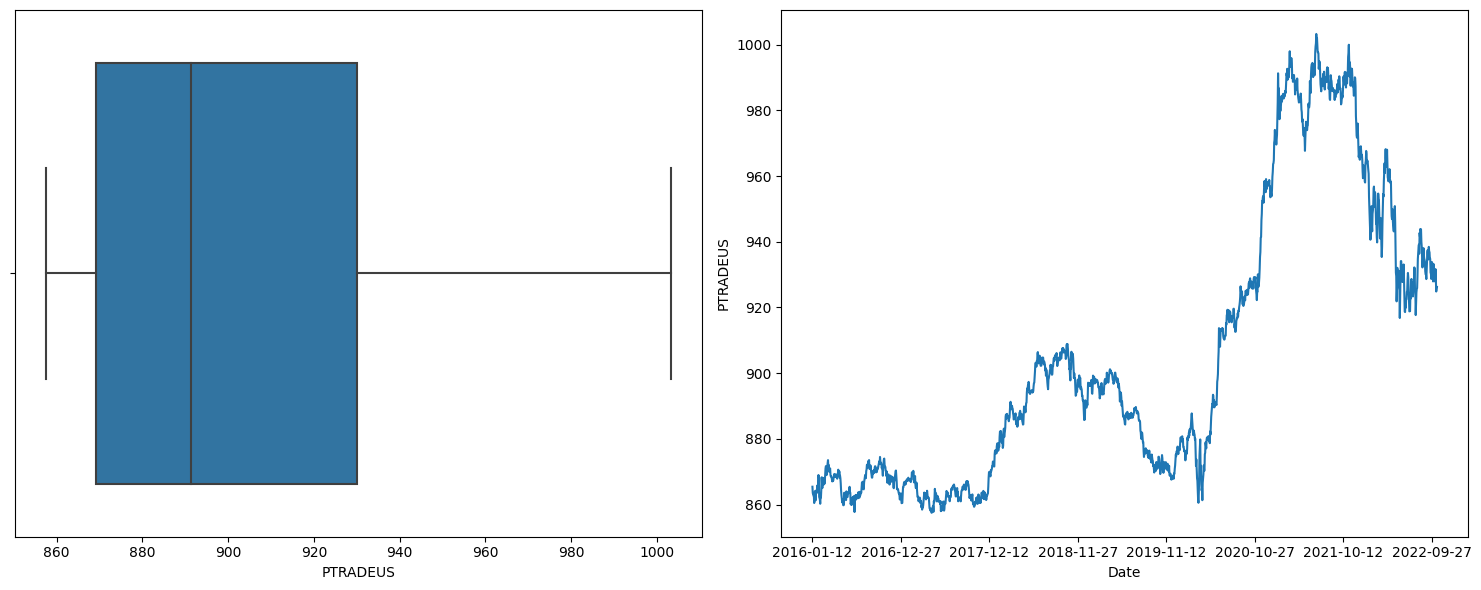

In [66]:
## Convert to PD 
df = pd.DataFrame(X_train_uns, columns=feature_names)  

## Variable
var = 'PTRADEUS'

## Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

## Boxplot on the first subplot
sns.boxplot(df[var], ax=axes[0])

## Line plot on the second subplot
df[var].plot(ax=axes[1])
axes[1].set_xlabel('Date')
axes[1].set_ylabel(var)

plt.tight_layout()
plt.show()

## Del
del fig, axes, var 

## Feature Selection

### 1- Boruta  

In [ ]:
## Define a naive Random Forest Classifier - IDEALLY YOU TUNE THAT BEFORE
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(y), 
                                random_state=rs, 
                                max_depth=5)

## Train the model
forest.fit(X_train_sca, y_train)

## Accuracy
print("Accuracy Score \t\t", accuracy_score(y_test, forest.predict(X_test_sca) )  )


## Run Boruta 
feat_selector = BorutaPy( forest, random_state=rs,
                          verbose=0, # 2 print detailed logs
                          n_estimators='auto', 
                          max_iter= 200, # default
                          perc=50, )                   
                        

## Find all relevant features
feat_selector.fit(X_train_sca, y_train)

## Rank Threshold
rank_threshold = 10

## Select features that respect the threshold  
feat_selector.support_ = [True if rank <= rank_threshold else False for rank in feat_selector.ranking_]

## Feature Rank
feature_ranks = list(zip(feature_names, feat_selector.ranking_, feat_selector.support_))

## Sort 
feature_ranks = sorted(feature_ranks, key=lambda x: x[1])

## Print Number of Features
print(f'Number of features selected: {sum(rank <= rank_threshold for rank in feat_selector.ranking_)}')

## Print Rank
for feat in feature_ranks:
    print(f'Feature: {feat[0]:<30} Rank: {feat[1]:<5} Keep: {feat[2]}')

## Filter Selected Variables
feat_boruta = [feature_names[i] for i, is_selected in enumerate(feat_selector.support_) if is_selected]   

X_train_filt_1 = pd.DataFrame( feat_selector.transform(X_train_sca), columns= feat_boruta )

X_test_filt_1 = pd.DataFrame( feat_selector.transform(X_test_sca), columns= feat_boruta  )

## Save/Load Features 
#pd.DataFrame(feat_boruta).to_csv('../Output/feat_engineering/feat_boruta.csv', index=False, header=False)
#feat_boruta = pd.read_csv('../Output/feat_engineering/feat_boruta.csv', index_col=0)

### 2- Correlation

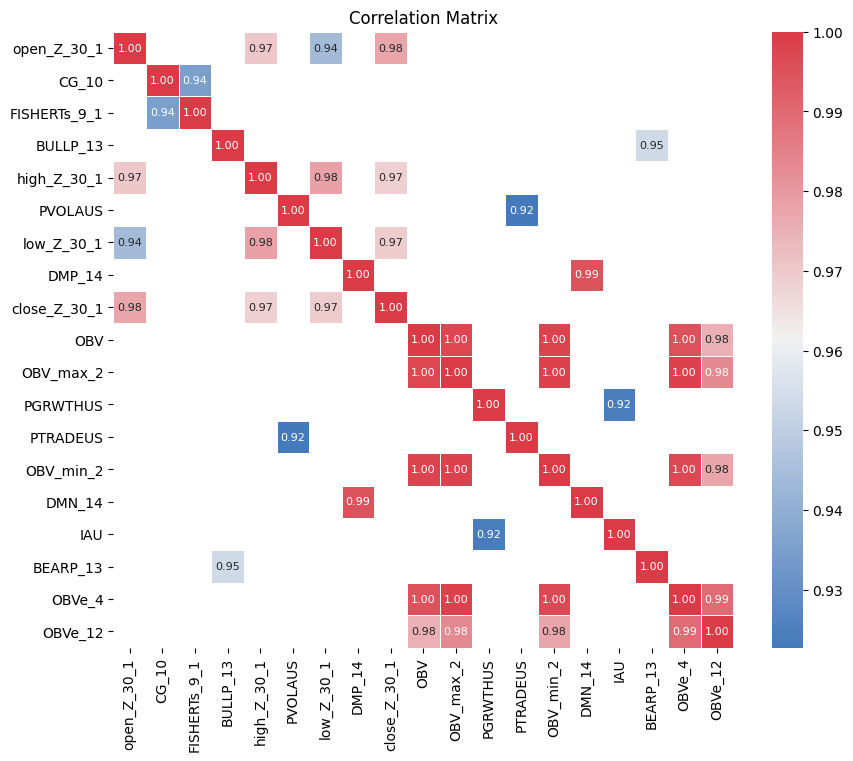

In [68]:
## Correlation Threshold
cor_threshold = 0.9

## Identify variables that have a correlation above the threshold
highly_correlated_vars = set()
corr_matrix = X_train_filt_1.corr()
num_features = corr_matrix.shape[0]

for i in range(num_features):
    for j in range(i + 1, num_features):
        if abs(corr_matrix.iloc[i, j]) > cor_threshold:
            highly_correlated_vars.add(corr_matrix.columns[i])
            highly_correlated_vars.add(corr_matrix.columns[j])

## Create X_train_cor with only the variables that meet the correlation threshold
X_train_cor = X_train_filt_1[list(highly_correlated_vars)]

## Create a mask for correlations above and below the threshold
mask = np.abs(X_train_cor.corr()) > cor_threshold

## Create a custom colormap for red and blue
cmap = sns.diverging_palette(250, 10, as_cmap=True)

## Plot the correlation matrix with red for above threshold and blue for below threshold
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_cor.corr(), annot=True, annot_kws={"size": 8}, fmt=".2f", linewidth=0.5, cmap=cmap, cbar=True, mask=~mask)
plt.title('Correlation Matrix')

## Save 
plt.savefig('../../Plot/Feature Selection/correlation.pdf', format='pdf', bbox_inches='tight')

## Show
plt.show()

del cmap, mask, highly_correlated_vars, corr_matrix, num_features

#### Feature Selection 2

In [39]:
## Correlated Variables
#X_train_cor.columns

## Variables that should be drop after the correlation analysis
drop_cor = [ 'OBVe_12', 'OBVe_4', 'OBV_min_2', 'OBV_max_2', 'high_Z_30_1', 'low_Z_30_1', 'close_Z_30_1', 'BULLP_13', 'IAU', 'PTRADEUS' ] 

## Filter Selected Variables
X_train_filt_2 =  X_train_filt_1.drop( columns= drop_cor ).copy()
X_test_filt_2  =  X_test_filt_1.drop(  columns= drop_cor ).copy()

del drop_cor

### 3- Feature Importance

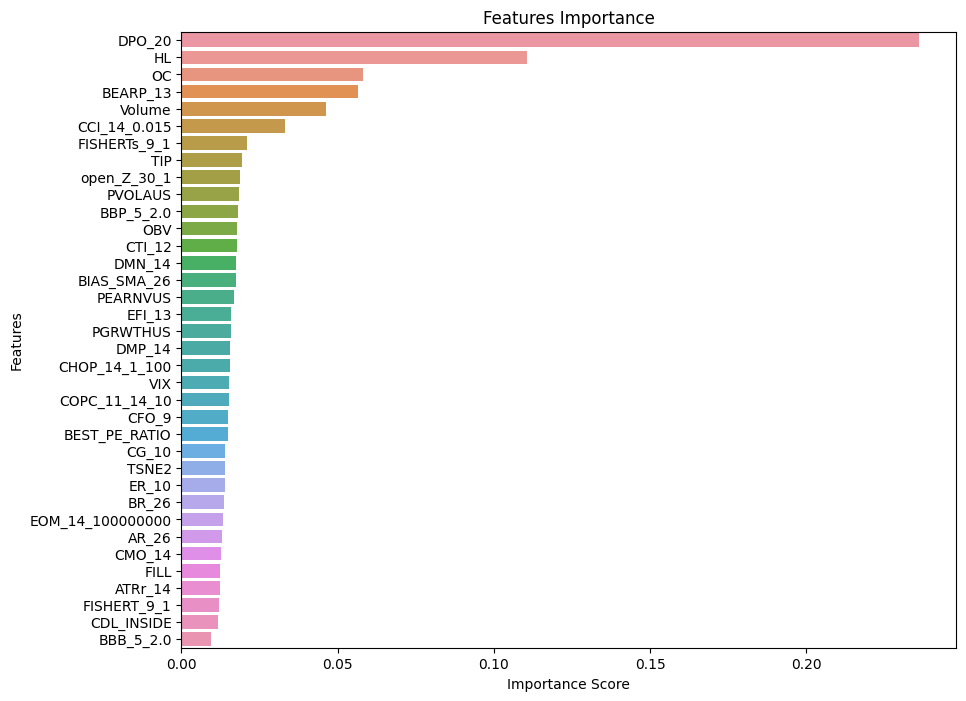

In [37]:

## Create Feature Importance
feature_imp = pd.DataFrame({'Importance Score': forest.feature_importances_,'Features': X_train_filt_2.columns}).sort_values(by='Importance Score', ascending=False)

## Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x=feature_imp['Importance Score'], 
            y=feature_imp['Features'])

## Set title
ax.set_title('Features Importance')

## Save 
plt.savefig('../../Plot/Feature Selection/feat_importance.pdf', format='pdf', bbox_inches='tight')

## Show 
plt.show()

del fig, ax, feature_imp


#### Feature Selection 3

In [67]:
## Correlated Variables
# X_train_filt_2.columns

## Variables that should be drop after the correlation analysis
drop_fi = [ 'BBP_5_2.0', 'CDL_INSIDE', 'FISHERT_9_1', 'ATRr_14' ] 

## Filter Selected Variables
X_train =  X_train_filt_2.drop( columns= drop_fi ).copy()
X_test  =  X_test_filt_2.drop(  columns= drop_fi ).copy()

## Join
X_final = pd.concat([X_train, X_test], axis=0, ignore_index=True)
df_final = pd.concat([ X_final, pd.Series(y, name='Target')],  axis=1)
df_final.index = X.index


## Save
df_final.to_csv('../../Data/df_final.csv', index=True)
spy.to_csv('../../Data/spy.csv', index=True)

del drop_fi

### Test 

In [59]:
## Filter 1
forest.fit(X_train_filt_1, y_train)
print("Accuracy Score Filter 1 \t\t", accuracy_score(y_test, forest.predict(X_test_filt_1) )  )

## Filter 2
forest.fit(X_train_filt_2, y_train)
print("Accuracy Score Filter 2 \t\t", accuracy_score(y_test, forest.predict(X_test_filt_2) )  )

## Filter 3
forest.fit(X_train, y_train)
print("Accuracy Score Filter 3 \t\t", accuracy_score(y_test, forest.predict(X_test) )  )

Accuracy Score Filter 1 		 0.6762820512820513
Accuracy Score Filter 2 		 0.6762820512820513
Accuracy Score Filter 3 		 0.6730769230769231
